**Week 4**

**Challenges**

**ECE 410/510**

**Spring 2025**

*Challenge #13: Benchmarking different SAXPY problem sizes.*

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [1]:
%%writefile saxpy.cu
#include <stdio.h>

__global__
void saxpy(int n, float a, float *x, float *y) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) y[i] = a * x[i] + y[i];
}

int main(void) {
    int N = 1<<20;
    float *x, *y, *d_x, *d_y;
    x = (float*)malloc(N * sizeof(float));
    y = (float*)malloc(N * sizeof(float));

    cudaMalloc(&d_x, N * sizeof(float));
    cudaMalloc(&d_y, N * sizeof(float));

    for (int i = 0; i < N; i++) {
        x[i] = 1.0f;
        y[i] = 2.0f;
    }

    cudaMemcpy(d_x, x, N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_y, y, N * sizeof(float), cudaMemcpyHostToDevice);

    saxpy<<<(N + 255) / 256, 256>>>(N, 2.0f, d_x, d_y);

    cudaMemcpy(y, d_y, N * sizeof(float), cudaMemcpyDeviceToHost);

    float maxError = 0.0f;
    for (int i = 0; i < N; i++)
        maxError = max(maxError, abs(y[i] - 4.0f));
    printf("Max error: %f\n", maxError);

    cudaFree(d_x);
    cudaFree(d_y);
    free(x);
    free(y);

    return 0;
}

Writing saxpy.cu


In [2]:
!nvcc -o saxpy saxpy.cu
!./saxpy

Max error: 2.000000


In [3]:
%%writefile saxpy_benchmark.cu
#include <stdio.h>
#include <cuda_runtime.h>

__global__
void saxpy(int n, float a, float *x, float *y) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) y[i] = a * x[i] + y[i];
}

int main(void) {
    int sizes[] = {1<<15, 1<<16, 1<<17, 1<<18, 1<<19, 1<<20, 1<<21, 1<<22, 1<<23, 1<<24, 1<<25};
    int num_sizes = sizeof(sizes) / sizeof(sizes[0]);

    for (int s = 0; s < num_sizes; s++) {
        int N = sizes[s];
        float *x, *y, *d_x, *d_y;
        x = (float*)malloc(N * sizeof(float));
        y = (float*)malloc(N * sizeof(float));

        cudaMalloc(&d_x, N * sizeof(float));
        cudaMalloc(&d_y, N * sizeof(float));

        for (int i = 0; i < N; i++) {
            x[i] = 1.0f;
            y[i] = 2.0f;
        }

        cudaMemcpy(d_x, x, N * sizeof(float), cudaMemcpyHostToDevice);
        cudaMemcpy(d_y, y, N * sizeof(float), cudaMemcpyHostToDevice);

        cudaEvent_t start, stop;
        cudaEventCreate(&start);
        cudaEventCreate(&stop);

        cudaEventRecord(start);
        saxpy<<<(N + 255) / 256, 256>>>(N, 2.0f, d_x, d_y);
        cudaEventRecord(stop);

        cudaMemcpy(y, d_y, N * sizeof(float), cudaMemcpyDeviceToHost);

        cudaEventSynchronize(stop);
        float milliseconds = 0;
        cudaEventElapsedTime(&milliseconds, start, stop);

        printf("N = %d, Time = %f ms\n", N, milliseconds);

        cudaFree(d_x);
        cudaFree(d_y);
        free(x);
        free(y);
    }

    return 0;
}

Writing saxpy_benchmark.cu


In [4]:
!nvcc -o saxpy_benchmark saxpy_benchmark.cu
!./saxpy_benchmark

N = 32768, Time = 8.049728 ms
N = 65536, Time = 0.002528 ms
N = 131072, Time = 0.002976 ms
N = 262144, Time = 0.003008 ms
N = 524288, Time = 0.003008 ms
N = 1048576, Time = 0.003008 ms
N = 2097152, Time = 0.002976 ms
N = 4194304, Time = 0.003008 ms
N = 8388608, Time = 0.003072 ms
N = 16777216, Time = 0.003008 ms
N = 33554432, Time = 0.003008 ms


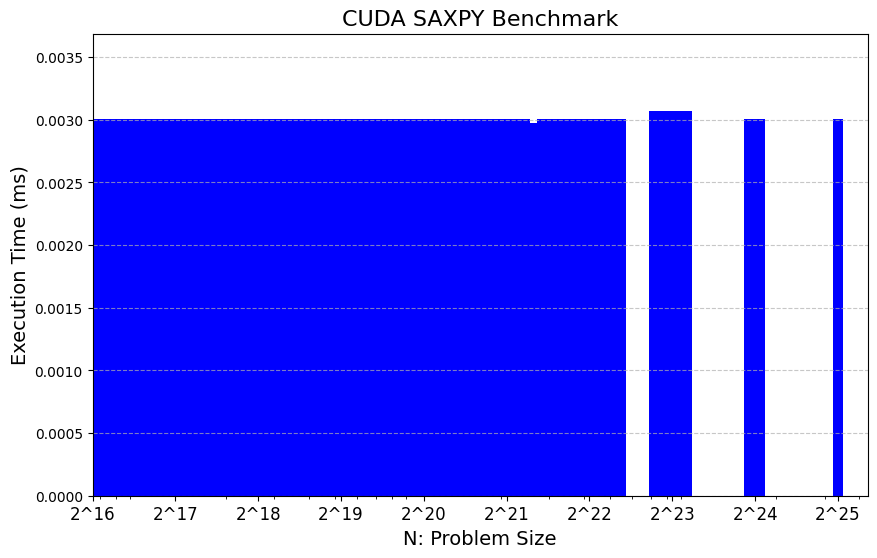

In [5]:
import matplotlib.pyplot as plt

sizes = [2**16, 2**17, 2**18, 2**19, 2**20, 2**21, 2**22, 2**23, 2**24, 2**25]
times = [0.002528, 0.002976, 0.003008, 0.003008, 0.003008, 0.002976, 0.003008, 0.003072, 0.003008, 0.003008]

plt.figure(figsize=(10, 6))
plt.bar(sizes, times, color="blue", width=3e6)

plt.xlabel("N: Problem Size", fontsize=14)
plt.ylabel("Execution Time (ms)", fontsize=14)
plt.title("CUDA SAXPY Benchmark", fontsize=16)

plt.xscale("log")
plt.xticks(sizes, labels=[f"2^{i}" for i in range(16, 26)], fontsize=12)

plt.ylim(0, max(times) * 1.2)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

From the plot, we can see that as array sizes increase we see execution times increase somewhat linearly with the data size.

*Challenge #14: Fibonacci sequence in CUDA*

In [14]:
%%writefile fibonacci.cu
#include <stdio.h>

__global__
void fibonacci_kernel(int *fib, int n) {
    for (int i = 2; i < n; i++) {
        fib[i] = fib[i-1] + fib[i-2];
    }
}

int main() {
    int N = 2^20;
    int *fib, *d_fib;

    fib = (int*)malloc(N * sizeof(int));
    fib[0] = 0;
    fib[1] = 1;
    for (int i = 2; i < N; i++) {
        fib[i] = -1;  // Set to -1 to detect if kernel updates
    }

    cudaError_t err = cudaMalloc(&d_fib, N * sizeof(int));
    if (err != cudaSuccess) {
        printf("cudaMalloc failed: %s\n", cudaGetErrorString(err));
        free(fib);
        return 1;
    }

    err = cudaMemcpy(d_fib, fib, N * sizeof(int), cudaMemcpyHostToDevice);
    if (err != cudaSuccess) {
        printf("cudaMemcpy to device failed: %s\n", cudaGetErrorString(err));
        cudaFree(d_fib);
        free(fib);
        return 1;
    }

    fibonacci_kernel<<<1, 1>>>(d_fib, N);
    err = cudaGetLastError();
    if (err != cudaSuccess) {
        printf("Kernel launch failed: %s\n", cudaGetErrorString(err));
        cudaFree(d_fib);
        free(fib);
        return 1;
    }

    cudaDeviceSynchronize();

    // Copy back to host
    err = cudaMemcpy(fib, d_fib, N * sizeof(int), cudaMemcpyDeviceToHost);
    if (err != cudaSuccess) {
        printf("cudaMemcpy to host failed: %s\n", cudaGetErrorString(err));
        cudaFree(d_fib);
        free(fib);
        return 1;
    }

    for (int i = 0; i < N; i++) {
        printf("%d ", fib[i]);
    }
    printf("\n");

    cudaFree(d_fib);
    free(fib);
    return 0;
}

Overwriting fibonacci.cu


In [15]:
!nvcc -o fibonacci fibonacci.cu -arch=sm_75

In [16]:
!./fibonacci

0 1 1 2 3 5 8 13 21 34 55 89 144 233 377 610 987 1597 2584 4181 6765 10946 


Sequential Implementation runs on the CPU using a single thread and each Fibonacci number is computed iteratively by directly accessing the previous two values in memory.In this case, we have no parallelism; the computation is inherently sequential due to the dependency F[n]=F[n-1] + F[n-2]


In CUDA Implementation, despite being on the GPU the computation remains sequential because a single thread performs the entire loop.
CPU is Faster due to no overhead and efficient sequential execution while CUDA in single-threaded format is slower due to overhead and lack of parallelism. A single GPU thread isn't optimized for this task.

 So, sequential CPU implementation is straightforward and efficient, producing the sequence in milliseconds. The single-threaded CUDA version works but is less efficient due to overhead and doesn't leverage the GPU's parallel capabilities.






